
## 1. Imports

In [ ]:
pip install datasets

In [ ]:
import numpy as np
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datasets import Dataset
from google.colab import drive
drive.mount('/content/drive') # Mount Google Drive


Mounted at /content/drive


## 2. Dataset load

In [ ]:
#TEXT_FILE = "train.txt"
TEXT_FILE = "/content/drive/MyDrive/StudentsPack/train.txt"
file = open(TEXT_FILE, "r", encoding="utf-8")
data = file.readlines()

data = [i.split("\t") for i in data]

df = [[row[2], row[4]] for row in data]  # Extract 2nd and 4th elements
df = pd.DataFrame(df, columns = ['genre', 'plot'])
print(df.head())


     genre                                               plot
0  romance  Sekhar (Tarun) is a graduate from IIM and work...
1   horror  Kris Fowles (Katie Cassidy) goes to the Spring...
2   horror  Cynthia is traumatized by the death of her bab...
3    crime  Four friends, Gangu (Jackie Shroff), Abdul (Na...
4    drama  Crisis in a middle-class family when the son f...


Mounted at /content/drive


## 3. Pre-processing

In [ ]:
# 3. Preprocessing
random_state=42
#MODEL_NAME = 'distilbert-base-cased'
MODEL_NAME= 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

# Define a function to tokenize the input data
def tokenize_function(examples):
    return tokenizer(examples["plot"], padding="max_length", truncation=True)

# Map genres to integers for classification
genre_labels = {genre: idx for idx, genre in enumerate(df['genre'].unique())}
df['genre_label'] = df['genre'].map(genre_labels)

# Convert the dataframe to Hugging Face dataset format
dataset = Dataset.from_pandas(df[['plot', 'genre_label']])

# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/8041 [00:00<?, ? examples/s]

## Train/test split


In [ ]:
# 4. Train/Test Split
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, seed=random_state)
train_dataset = train_test_split["train"].map(lambda examples: {'labels': examples['genre_label']})
test_dataset = train_test_split["test"].map(lambda examples: {'labels': examples['genre_label']})

Map:   0%|          | 0/6432 [00:00<?, ? examples/s]

Map:   0%|          | 0/1609 [00:00<?, ? examples/s]

## Load DistilBERT Model for Sequence Classification


In [ ]:
num_labels = len(genre_labels)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define Metrics

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

## Train The Model

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.01,
    eval_strategy="steps",
    save_steps=500,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=True,
    seed=random_state
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,1.380400,1.021700,0.663766,0.670888,0.663766,0.662398
200,0.972600,1.004697,0.630205,0.700290,0.630205,0.619477
300,0.690000,0.884716,0.694842,0.690724,0.694842,0.689480
400,0.661100,0.851018,0.700435,0.705730,0.700435,0.700125
500,0.402500,0.900538,0.715351,0.717843,0.715351,0.714703
600,0.397100,0.941556,0.691112,0.700932,0.691112,0.693137
700,0.217000,1.008823,0.702921,0.705844,0.702921,0.701635
800,0.215400,1.041845,0.703543,0.707379,0.703543,0.702618
900,0.127300,1.069576,0.706029,0.706075,0.706029,0.704415
1000,0.118200,1.080042,0.710379,0.710672,0.710379,0.709303


TrainOutput(global_step=1005, training_loss=0.515915911707712, metrics={'train_runtime': 660.3091, 'train_samples_per_second': 48.704, 'train_steps_per_second': 1.522, 'total_flos': 4260683357061120.0, 'train_loss': 0.515915911707712, 'epoch': 5.0})

## Train The Model

In [ ]:
trainer.evaluate()

{'eval_loss': 0.9005380868911743,
 'eval_accuracy': 0.7153511497824736,
 'eval_precision': 0.7178433704122577,
 'eval_recall': 0.7153511497824736,
 'eval_f1': 0.7147029689930726,
 'eval_runtime': 9.3326,
 'eval_samples_per_second': 172.406,
 'eval_steps_per_second': 5.465,
 'epoch': 5.0}

## Plot the Confusion Matrices

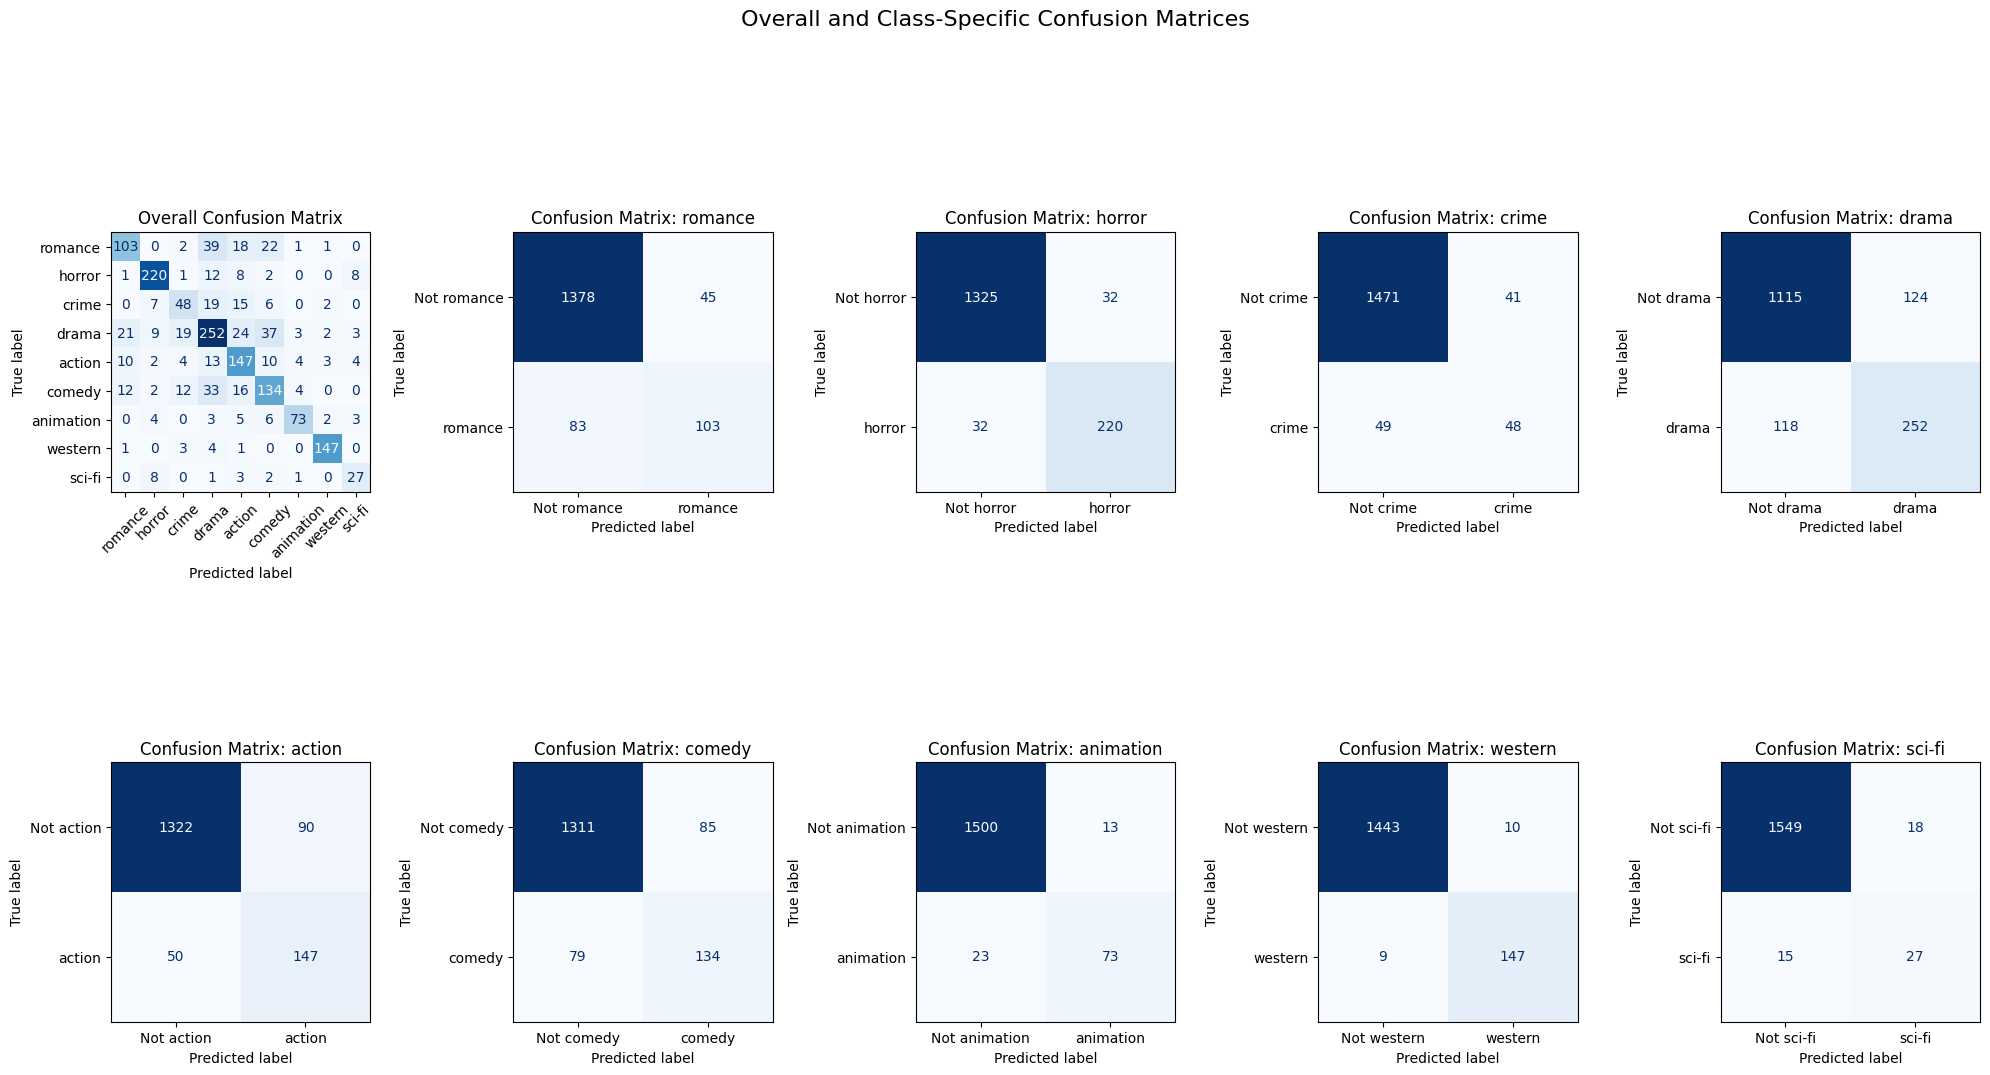

In [ ]:
# Generate overall confusion matrix
predictions = trainer.predict(test_dataset)
cm = confusion_matrix(test_dataset['labels'], predictions.predictions.argmax(axis=1))
genre_names = list(genre_labels.keys())  # Genre names from your labels

# Create a figure with subplots: one for the overall matrix + individual class matrices
num_genres = len(genre_names)
fig, axes = plt.subplots(2, (num_genres + 1) // 2, figsize=(20, 12))  # Adjust layout based on genres
fig.suptitle("Overall and Class-Specific Confusion Matrices", fontsize=16)

# Plot the overall confusion matrix on the first subplot
ax_overall = axes[0, 0]  # Place it in the first position
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_names)
disp.plot(cmap=plt.cm.Blues, ax=ax_overall, xticks_rotation=45,colorbar=False)
ax_overall.set_title("Overall Confusion Matrix")

# Plot individual confusion matrices for each genre
for i, genre in enumerate(genre_names):
    # Create binary confusion matrix for the current genre
    binary_true = [1 if label == i else 0 for label in test_dataset['labels']]
    binary_pred = [1 if label == i else 0 for label in predictions.predictions.argmax(axis=1)]
    class_cm = confusion_matrix(binary_true, binary_pred, labels=[0, 1])

    # Select the appropriate subplot position for the genre
    row = (i + 1) // ((num_genres + 1) // 2)
    col = (i + 1) % ((num_genres + 1) // 2)
    ax = axes[row, col]

    disp = ConfusionMatrixDisplay(confusion_matrix=class_cm, display_labels=[f"Not {genre}", genre])
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    ax.set_title(f"Confusion Matrix: {genre}")

    if col != 0:  # Not the first column, hide y-axis labels
        ax.set_ylabel('')
        ax.set_xlabel("Predicted Labels", fontsize=12, fontweight='bold')
    if col == 0 and row == 1:
        ax.set_xlabel("Predicted Labels", fontsize=12, fontweight='bold')
        ax.set_ylabel("True Labels", fontsize=12, fontweight='bold')

ax_overall.set_xlabel("Predicted Labels", fontsize=12, fontweight='bold')
ax_overall.set_ylabel("True Labels", fontsize=12, fontweight='bold')

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Kfold Validation on Train Set

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader

k = 5  # Set number of default folds
def k_fold_cross_val(model, dataset, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    accuracies = []

    for train_idx, test_idx in kf.split(dataset):
        train_split = dataset.select(train_idx)
        test_split = dataset.select(test_idx)

        #train_split = train_split.rename_column("genre_label", "labels")
        #test_split = test_split.rename_column("genre_label", "labels")


        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_split,
            eval_dataset=test_split,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )

        trainer.train()
        metrics = trainer.evaluate()
        accuracies.append(metrics['eval_accuracy'])

    return np.mean(accuracies), np.std(accuracies)

mean_acc, std_acc = k_fold_cross_val(model, tokenized_dataset, k)
print(f"K-Fold Cross Validation Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

ValueError: The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,attention_mask.

## Predict on Test Set

In [ ]:
# Load test set (without genre labels)
test_file = open("/content/drive/MyDrive/StudentsPack/test_no_labels.txt", "r", encoding="utf-8")
test_data = test_file.readlines()

# Preprocess the test data similar to the training data
test_plots = [plot.strip() for plot in test_data]
test_df = pd.DataFrame(test_plots, columns=["plot"])
test_dataset = Dataset.from_pandas(test_df)

# Tokenize test data
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Make predictions
predictions = trainer.predict(tokenized_test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Map predicted labels back to genres
predicted_genres = [list(genre_labels.keys())[label] for label in predicted_labels]

# Save the results
with open("results.txt", "w", encoding="utf-8") as results_file:
    for genre in predicted_genres:
        results_file.write(genre + "\n")

Map:   0%|          | 0/400 [00:00<?, ? examples/s]